In [1]:

import tensorflow as tf
import keras
from keras.callbacks import EarlyStopping, Callback
import numpy as np
import matplotlib.pyplot as plt
#from tf.keras.preprocessing.image import ImageDataGenerator

# from model_NO_AF import model_maker
# from model_ALL_RELU import model_maker
#from model_ALL_TANH import model_maker+
# from model_ALL_MISH import model_maker
# from model_ALL_SMISH import model_maker

# from model_TEED_RELU import model_maker
# from model_TEED_TANH import model_maker
# from model_TEED_MISH import model_maker
# from model_TEED_SMISH import model_maker

from model_TEED_SMISH_x import model_maker
#from model_TEED_SMISH_l import model_maker
# from model import model_maker



print(tf.__version__)
print(keras.__version__)


2.17.0
3.5.0


In [2]:
# plotting helper function
def plothist(hist):
    plt.plot(hist.history["accuracy"]) #'acc'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Custom callback to stop training when accuracy is above 95%
class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['val_accuracy'] > 0.95:
            print(f'\nReached 95% validation accuracy. Stopping training.')
            self.model.stop_training = True

In [3]:
def dataset_maker(dataset_name):
    
    if dataset_name =="cifar10":
        # train 50000, 10000
        (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
        x_train=x_train.astype("float32")  
        x_test=x_test.astype("float32")
        
        mean=np.mean(x_train)
        std=np.std(x_train)
        x_test=(x_test-mean)/std
        x_train=(x_train-mean)/std
        
        class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']
        
        x_train = x_train.reshape((50000, 32, 32, 3))
        x_test = x_test.reshape((10000, 32, 32, 3))
        
        return [x_train,y_train], [x_test, y_test]
    
    elif dataset_name =="cifar100":
        # train 50000, 10000
        (x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()
        
        mean=np.mean(x_train)
        std=np.std(x_train)
        x_test=(x_test-mean)/std
        x_train=(x_train-mean)/std
        
        
        class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
        
        x_train = x_train.reshape((50000, 32, 32, 3))
        x_test = x_test.reshape((10000, 32, 32, 3))
        
        return [x_train,y_train], [x_test, y_test]
    
    else:
        
        print("Unrecognized dataset")
        


In [4]:
dataset_name = ["mnist","mnist_fashion","cifar10", "cifar100"]
data = dataset_name[2]

if data=="cifar10" or data=="cifar100":
    image_size =(32, 32,3) 
else:
    image_size = (28, 28,1)
    
batch_size = 32
N_classes = 100 if data=="cifar100" else 10

training, testing = dataset_maker(data)
x_train, y_train = training
x_test, y_test = testing

print(data,"data size")
print("Training:", x_train.shape, y_train.shape)
print("Testing:", x_test.shape, y_test.shape)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, N_classes)
y_test = keras.utils.to_categorical(y_test, N_classes)
print("Target size", data,image_size)
print("Training:", y_train.shape)
print("Testing:", y_test.shape)



cifar10 data size
Training: (50000, 32, 32, 3) (50000, 1)
Testing: (10000, 32, 32, 3) (10000, 1)
Target size cifar10 (32, 32, 3)
Training: (50000, 10)
Testing: (10000, 10)


In [5]:
# Build the model
model = keras.Sequential()
model.add(keras.Input(shape=x_train.shape[1:]))
    # CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(keras.layers.BatchNormalization(axis=-1))    
model.add(keras.layers.Conv2D(32, (3, 3), padding='same'))
model.add(keras.layers.Activation('relu'))

model.add(keras.layers.Conv2D(32, (3, 3)))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(keras.layers.Conv2D(64, (3, 3), padding='same'))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.BatchNormalization(axis=-1))
model.add(keras.layers.Conv2D(64, (3, 3)))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))

# FLATTERN => DENSE => RELU => DROPOUT
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))
# a softmax classifier
model.add(keras.layers.Dense(N_classes))
model.add(keras.layers.Activation('softmax'))


#model = model_maker(image_size,N_classes)
# keras.utils.plot_model(model, show_shapes=True)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization                  │ (None, 32, 32, 3)           │              12 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 30, 30, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 15, 15, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 15, 15, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 10)                  │              

 Total params: 659,510 (2.52 MB)

 Trainable params: 658,864 (2.51 MB)

 Non-trainable params: 646 (2.52 KB)

In [6]:
# set up image augmentation
#datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#    rotation_range=15,
##    horizontal_flip=True,
#    width_shift_range=0.1,
#    height_shift_range=0.1,
 #   validation_split=0.15,
#    #zoom_range=0.3
#    )
#datagen.fit(x_train)

#datagen = keras.Sequential([
    #keras.layers.RandomFlip("horizontal"),
    #keras.layers.RandomFlip("vertical"),
#    keras.layers.RandomFlip("horizontal_and_vertical"),
 #   keras.layers.RandomContrast(0.2)
#], name='data_augmentation'    
#)

#datagen.fit(x_train)


In [7]:
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
epochs = 50  # 5, 10, 15, 20
n_batches = 32

# compile the model
# model.compile(loss=keras.losses.SparseCategoricalCrossentropy(), 
#               optimizer=keras.optimizers.AdamW(), 
#               metrics=[keras.metrics.SparseCategoricalAccuracy()]) # second optimizer

#model.compile(loss=keras.losses.SparseCategoricalCrossentropy(), 
#              optimizer=keras.optimizers.AdamW(learning_rate=0.0001), 
#              metrics=[keras.metrics.SparseTopKCategoricalAccuracy(k=1)]) # second optimizer and accuracy
#model.compile(loss=keras.losses.CategoricalCrossentropy(), 
#              optimizer=keras.optimizers.AdamW(learning_rate=0.0001), 
#              metrics=[keras.metrics.Accuracy()]) # second optimizer and accuracy
#model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
#model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.AdamW(learning_rate=0.001), metrics=["accuracy"])
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001, weight_decay=2e-4),
              metrics=["accuracy"]) # lr 8e-5 2e-4 ["accuracy"]

image_size

(32, 32, 3)

In [8]:
# start training
history = model.fit(x_train, y_train, epochs=epochs,
                    validation_split=0.15,batch_size=n_batches,shuffle=True)# validation_split=0.2

Epoch 1/50
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 43s 30ms/step - accuracy: 0.3887 - loss: 1.8672 - val_accuracy: 0.6320 - val_loss: 1.0829
Epoch 2/50
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 39s 29ms/step - accuracy: 0.6325 - loss: 1.0545 - val_accuracy: 0.6873 - val_loss: 0.8949
Epoch 3/50
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 43s 32ms/step - accuracy: 0.6894 - loss: 0.8856 - val_accuracy: 0.6867 - val_loss: 0.8997
Epoch 4/50
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 43s 32ms/step - accuracy: 0.7166 - loss: 0.8030 - val_accuracy: 0.7036 - val_loss: 0.8621
Epoch 5/50
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - accuracy: 0.7496 - loss: 0.7248 - val_accuracy: 0.7212 - val_loss: 0.8137
Epoch 6/50
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - accuracy: 0.7667 - loss: 0.6797 - val_accuracy: 0.7432 - val_loss: 0.7578
Epoch 7/50
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.7836 - loss: 0.6243 - val_accuracy: 0.7933 - val_loss: 0.6027
Epoch 8/50
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.7963 -

In [9]:
model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8265 - loss: 0.5654


[0.5781480669975281, 0.8205000162124634]

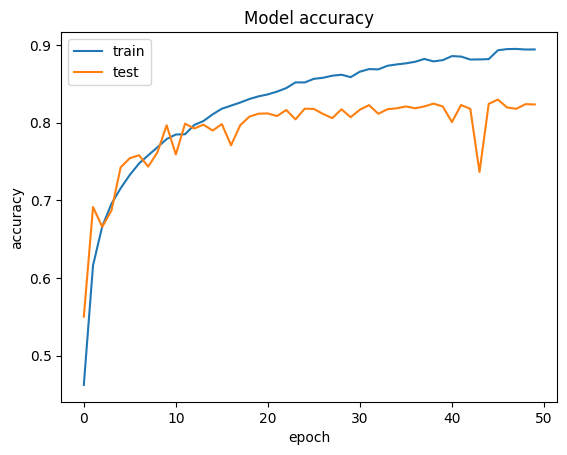

In [10]:
plothist(history)

In [20]:
#!pip install matplotlib

In [ ]:
fig, ax = plt.subplots(1, len(class_names), figsize=(20, 20))
        for i in range(len(class_names)):
            class_indices = np.where(y_test == i)[0]
            random_index = random.choice(class_indices)
            ax[i].imshow(x_test[random_index])
            ax[i].axis('off')
            ax[i].set_title(class_names[i])
        plt.show()